In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
# Question 3
def generate_distribution(n):
    p = np.random.random(n)
    x = np.arange(0,n)
    return p/p.sum(),x

def generate_variable(p,x):
    u = np.random.random()
    F = 0
    for i in range(len(p)):      
        if u >= F and u < F + p[i]:
            return x[i]
        F = F + p[i]
    return x[-1]


def generate_sequence(p, x, N):
    return [generate_variable(p,x) for i in range(N)]


def generate_gaussian_mixture(mu,sigma,alpha,label):
    i = generate_variable(alpha,label)
    return np.random.multivariate_normal(mu[i],sigma[i]), i


def f(xy, sigma, mu):
    lambd = np.linalg.inv(sigma)
    X = np.add(xy,-mu)
    sX = np.matmul(lambd,np.transpose(X))
    A = np.array([np.dot(X[i],sX[:,i]) for i in range(X.shape[0])])
    det = np.linalg.det(lambd)**(0.5)
    return 1/(2*np.pi)*det*np.exp(-A)*1000

#différent Tn possible
def T1(n):
    T0 = 100
    r = 1.5
    a= 0.02
    b=20
    return np.maximum(np.tanh(n/(2*r)) + (T0 - b*2*np.sqrt(2)/(3*np.pi))*a**(n/r) + b*np.sinc(3/4 + n/(np.pi*r)),0.1)

def T2(n):
    return 1

def T3(n):
    return 1 + 10/(n+1)

def T4(n):
    T0 = 100
    r = 1.5
    return 1 + (T0 - 1)*np.exp(-r*n)

#####################################################################
#Fonction de l'algo
def EM(X, m, T, mu_start):
    n_iter = 0
    n = X.shape[1]
    loglikelihood = []
    alpha = np.arange(1,m+1)
    alpha = alpha/alpha.sum()
    mu = mu_start
    sigma = np.reshape(np.array([np.eye(n) for i in range(m)]),(m,n,n))
    loglikelihood.append(get_loglikelihood(alpha, mu, sigma, X))
    new_alpha, new_mu, new_sigma = maximize(alpha, mu, sigma, X, T(0))
    while n_iter<50:
        n_iter+=1
        alpha, mu, sigma = new_alpha, new_mu, new_sigma
        new_alpha, new_mu, new_sigma = maximize(alpha, mu, sigma, X, T(n_iter))
        loglikelihood.append(get_loglikelihood(alpha, mu, sigma, X))
    return loglikelihood, alpha,sigma,mu, n_iter


def get_loglikelihood(alpha, mu, sigma, X):
    lambd = np.linalg.inv(sigma)
    det = np.linalg.det(lambd)**(0.5)
    l = 0
    for i in range(len(X)):
        p=0
        for j in range(mu.shape[0]):
            p += alpha[j]*1/(2*np.pi)*det[j]*np.exp(-0.5*np.dot(X[i]-mu[j],np.matmul(lambd[j],X[i]-mu[j])))
        l += np.log(p)
    return l

def maximize(alpha, mu, sigma, X, Tn):
    m = alpha.shape[0]
    n = X.shape[1]
    alpha_t = []
    mu_t = []
    sigma_t = []
    lambd = np.linalg.inv(sigma)
    det = np.linalg.det(lambd)**(0.5)
    pzx = []
    for j in range(mu.shape[0]):
        pzx_j = []
        for i in range(len(X)):
            pzx_j.append(alpha[j]/(2*np.pi)*det[j]*np.exp(-0.5*np.dot(X[i]-mu[j],np.matmul(lambd[j],X[i]-mu[j]))))
        pzx.append(pzx_j)
    pzx = np.array(pzx)
    tau = pzx/np.sum(pzx,axis=0)
    ##################################
    #changement du tempered EM
    tau = tau**(1/Tn)
    tau = tau/np.sum(tau,axis=0)
    ##################################
    sum_tau = np.sum(tau,axis=1)
    alpha_t = sum_tau/len(X)
    mu_t = np.transpose(np.transpose(np.matmul(tau,X))*1/sum_tau)
    for j in range(mu.shape[0]):
        sigma_j = np.zeros(sigma[0].shape)
        for i in range(len(X)):
            sigma_j+=tau[j,i]*np.matmul(np.reshape(X[i]-mu_t[j],(mu.shape[1],1)),np.reshape(X[i]-mu_t[j],(1,mu.shape[1])))
        sigma_t.append(sigma_j/sum_tau[j])
    return alpha_t, mu_t, np.array(sigma_t)

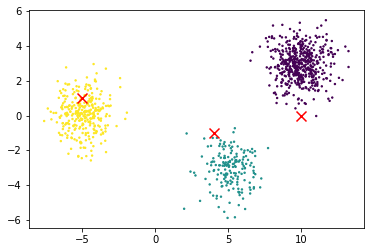

In [80]:
#Create and display data
np.random.seed()
m = 3
mu_true = np.array([np.array([10,3]), np.array([5,-3]), np.array([-5,0])])
sigma_true = np.array([np.array([[1,0],[0,1]]),np.array([[1,0],[0,1]]), np.array([[1,0],[0,1]])])
mu_start = np.array([np.array([-5,1]), np.array([4,-1]), np.array([10,0])])
alpha_true, labels = generate_distribution(m)
X = []
label = []
N = 1000
for i in range(N):
    Xi, labeli = generate_gaussian_mixture(mu_true,sigma_true,alpha_true,labels)
    X.append(Xi)
    label.append(labeli)
X =np.array(X)
plt.scatter(X[:,0], X[:,1], c = label, s=2)
plt.scatter(mu_start[:,0], mu_start[:,1], marker='x', s = 100, c='r')

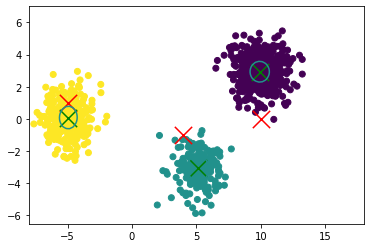

50


In [97]:
#compute and plot theta using Tn = 1
like,alpha_est,sigma_est,mu_est, n_iter = EM(X,m, T2, mu_start)

x, y = np.meshgrid(np.linspace(-8,18,100),np.linspace(-5,7,100))
xy = np.column_stack([x.flat, y.flat])
for i in range(3):
    z = f(xy, sigma_est[i], mu_est[i]).reshape(x.shape)
    plt.contour(x, y, z, levels=1)
plt.scatter(X[:,0], X[:,1], c = label)
plt.scatter(mu_start[:,0], mu_start[:,1], marker='x', s = 300, c='r')
plt.scatter(mu_est[:,0], mu_est[:,1], marker='x', s = 300, c='g')
plt.show()
print(n_iter)

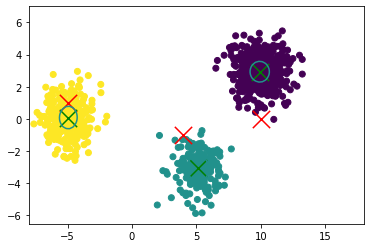

In [98]:
#compute and plot theta using Tn = 1 + 10/(n+1)
like,alpha_est,sigma_est,mu_est, n_iter = EM(X,m, T2, mu_start)

x, y = np.meshgrid(np.linspace(-8,18,100),np.linspace(-5,7,100))
xy = np.column_stack([x.flat, y.flat])
for i in range(3):
    z = f(xy, sigma_est[i], mu_est[i]).reshape(x.shape)
    plt.contour(x, y, z, levels=1)
plt.scatter(X[:,0], X[:,1], c = label)
plt.scatter(mu_start[:,0], mu_start[:,1], marker='x', s = 300, c='r')
plt.scatter(mu_est[:,0], mu_est[:,1], marker='x', s = 300, c='g')
plt.show()

In [100]:
#compute and plot theta using Tn = np.maximum(np.tanh(n/(2*r)) + (T0 - b*2*np.sqrt(2)/(3*np.pi))*a**(n/r) + b*np.sinc(3/4 + n/(np.pi*r)),0.1)
like,alpha_est,sigma_est,mu_est, n_iter = EM(X,m, T1, mu_start)

x, y = np.meshgrid(np.linspace(-8,18,100),np.linspace(-5,7,100))
xy = np.column_stack([x.flat, y.flat])
for i in range(3):
    z = f(xy, sigma_est[i], mu_est[i]).reshape(x.shape)
    plt.contour(x, y, z, levels=1)
plt.scatter(X[:,0], X[:,1], c = label)
plt.scatter(mu_start[:,0], mu_start[:,1], marker='x', s = 300, c='r')
plt.scatter(mu_est[:,0], mu_est[:,1], marker='x', s = 300, c='g')
plt.show()

LinAlgError: ignored

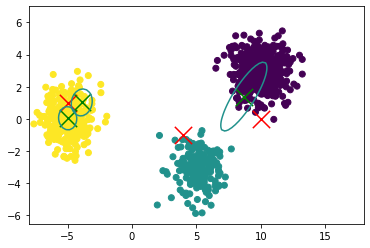

In [101]:
#compute and plot theta using Tn = 1 + (T0 - 1)*np.exp(-r*n)
like,alpha_est,sigma_est,mu_est, n_iter = EM(X,m, T4, mu_start)

x, y = np.meshgrid(np.linspace(-8,18,100),np.linspace(-5,7,100))
xy = np.column_stack([x.flat, y.flat])
for i in range(3):
    z = f(xy, sigma_est[i], mu_est[i]).reshape(x.shape)
    plt.contour(x, y, z, levels=1)
plt.scatter(X[:,0], X[:,1], c = label)
plt.scatter(mu_start[:,0], mu_start[:,1], marker='x', s = 300, c='r')
plt.scatter(mu_est[:,0], mu_est[:,1], marker='x', s = 300, c='g')

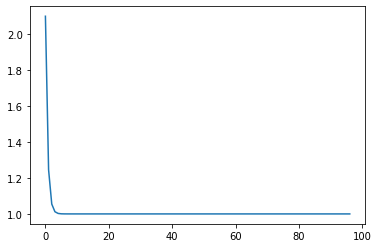

In [103]:
a = np.arange(3,100)
plt.plot(T4(a))